Files already downloaded and verified
Files already downloaded and verified


C:\Users\blue\AppData\Local\Temp\ipykernel_21968\963521806.py:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.log_softmax(x)


1 / 195 epoch: 0 | Loss: 4.841 | Acc: 2.344% (6/256)
2 / 195 epoch: 0 | Loss: 4.915 | Acc: 1.758% (9/512)
3 / 195 epoch: 0 | Loss: 4.902 | Acc: 1.432% (11/768)
4 / 195 epoch: 0 | Loss: 4.862 | Acc: 1.172% (12/1024)
5 / 195 epoch: 0 | Loss: 4.815 | Acc: 1.250% (16/1280)
6 / 195 epoch: 0 | Loss: 4.787 | Acc: 1.237% (19/1536)
7 / 195 epoch: 0 | Loss: 4.763 | Acc: 1.172% (21/1792)
8 / 195 epoch: 0 | Loss: 4.747 | Acc: 1.123% (23/2048)
9 / 195 epoch: 0 | Loss: 4.727 | Acc: 1.172% (27/2304)
10 / 195 epoch: 0 | Loss: 4.713 | Acc: 1.250% (32/2560)
11 / 195 epoch: 0 | Loss: 4.701 | Acc: 1.314% (37/2816)
12 / 195 epoch: 0 | Loss: 4.690 | Acc: 1.432% (44/3072)
13 / 195 epoch: 0 | Loss: 4.680 | Acc: 1.472% (49/3328)
14 / 195 epoch: 0 | Loss: 4.668 | Acc: 1.562% (56/3584)
15 / 195 epoch: 0 | Loss: 4.656 | Acc: 1.771% (68/3840)
16 / 195 epoch: 0 | Loss: 4.643 | Acc: 1.831% (75/4096)
17 / 195 epoch: 0 | Loss: 4.632 | Acc: 1.884% (82/4352)
18 / 195 epoch: 0 | Loss: 4.622 | Acc: 1.888% (87/4608)
19 / 1

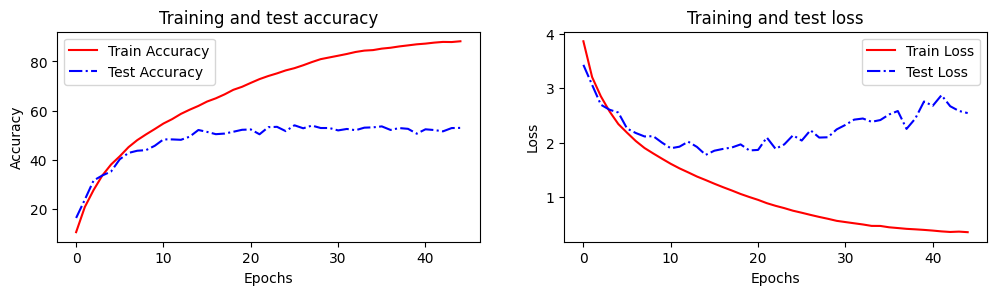

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, drop_last=True)


class Attention(nn.Module):
    def __init__(self, in_channels):
        super(Attention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=(1, 1), bias=False)
    def forward(self, x):
        a = nn.functional.relu(self.conv(x))
        a = nn.functional.log_softmax(a.view(a.size(0), -1), dim=1).view_as(a)
        x = x * a
        return x


class GRUnet(nn.Module):
    def __init__(self):
        super(GRUnet, self).__init__() 
        self.model0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=2, padding=2),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1),  
        )
        self.model1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.R1 = nn.ReLU()
        self.en1 = nn.Sequential( 
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),   
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.model2 = nn.Sequential(     
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.R2 = nn.ReLU()
        self.model3 = nn.Sequential(      
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.R3 = nn.ReLU()

        self.aap = nn.AdaptiveAvgPool2d((4, 4))   
        self.flatten = nn.Flatten(start_dim=1)
        self.fc0 = nn.Linear(2048, 1024)        
        self.gru = nn.GRU(32, 64, 1, bidirectional=True, batch_first=True)
        self.attention1 = Attention(256)
        self.fc1 = nn.Linear(128, 100)

    def forward(self, x):
        x = self.model0(x)

        f1 = x
        x = self.model1(x)
        x = x + f1
        x = self.R1(x)

        f2 = x
        f2 = self.en1(f2)
        x = self.model2(x)
        x = x + f2
        x = self.R2(x)

        f3 = x
        x = self.model3(x)
        x = x + f3
        x = self.R3(x)


        x = self.aap(x)
        x = self.flatten(x)    
        x = nn.functional.relu(self.fc0(x))   
        x, (h_n, c_n) = self.gru(x.view(-1, 32, 32))  
        x = self.attention1(x)
        x = self.fc1(x[:, -1, :])

        x = nn.functional.log_softmax(x)
        return x


# Training
def train(net, train_epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
    for batch_index, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        optimizer.zero_grad()
        outputs = net(inputs)  # batch_size, sequence length, input_size
        loss = nn.functional.nll_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)  # 一张图一列，每列拿最大
        total += targets.size(0)  # 每一个batch中的数量
        correct += predicted.eq(targets).sum().item()
        Loss = train_loss / (batch_index + 1)
        Acc = 100. * correct / total
        print(batch_index + 1, '/', len(train_loader), 'epoch: %d' % train_epoch, '| Loss: %.3f | Acc: %.3f%% (%d/%d)'
              % (Loss, Acc, correct, total))
    return Loss, Acc


def evaluate(net, test_epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_index, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            outputs = net(inputs)  # batch_size, sequence length, input_size
            loss = nn.functional.nll_loss(outputs, targets)
            test_loss += loss.item() 
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            Loss = test_loss / (batch_index + 1)
            Acc = 100. * correct / total
            print(batch_index + 1, '/', len(train_loader), 'epoch: %d' % test_epoch,
                  '| Loss: %.3f | Acc: %.3f%% (%d/%d)'
                  % (Loss, Acc, correct, total))
        return Loss, Acc


def acc_line(Train_loss, Train_acc, Test_loss, Test_acc):
    # 绘制acc和loss曲线
    epochs = range(len(Train_acc))  # Get number of epochs
    # 创建一个图形，包含两行两列的子图
    plt.figure(figsize=(12, 6))
    # 第一个子图：训练和测试准确度曲线
    plt.subplot(2, 2, 1)
    plt.plot(epochs, Train_acc, 'r', linestyle='-')
    plt.plot(epochs, Test_acc, 'b', linestyle='dashdot')
    plt.title('Training and test accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train Accuracy", "Test Accuracy"])
    # 第二个子图：训练和测试损失曲线
    plt.subplot(2, 2, 2)
    plt.plot(epochs, Train_loss, 'r', linestyle='-')
    plt.plot(epochs, Test_loss, 'b', linestyle='dashdot')
    plt.title('Training and test loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Test Loss"])
    # 显示图形
    plt.show()


def main():
    train_epoch = 45
    test_epoch = 2
    net = GRUnet()
    net.to('cuda')
    # train
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in range(train_epoch):
        Loss, Acc = train(net, epoch)
        train_loss.append(Loss)
        train_acc.append(Acc)
        torch.save(net.state_dict(), './GRUMcifar100_1.pkl')
        Loss, Acc = evaluate(net, epoch)
        test_loss.append(Loss)
        test_acc.append(Acc)

    # test
    print('begin test')
    for epoch in range(test_epoch):
        evaluate(net, epoch)

    # plot
    acc_line(train_loss, train_acc, test_loss, test_acc)


if __name__ == "__main__":
    main()